In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)

# Model definition

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

class LeNetBlock(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__() 
        self.conv = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=5, stride=1)
    
    def forward(self, x):
        out = F.relu(F.max_pool2d(self.conv(x), 2))
        return out
    
class LeNet5Conv(nn.Module):

    def __init__(self, H_in, W_in, H_out=1, W_out=1):
        self.detection = False
        super().__init__() 
        self.block1 = LeNetBlock(c_in=1, c_out=6)
        # Shape: (H - 5 + 1) // 2 = 12 
        self.block2 = LeNetBlock(c_in=6, c_out=16)
        # Shape: (H - 5 + 1) // 2 = 4
        H_out_exp = (((H_in - 4) // 2) - 4) // 2
        W_out_exp = (((W_in - 4) // 2) - 4) // 2
        self.fc3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(H_out_exp-H_out+1, W_out_exp-W_out+1))
        self.fc4 = nn.Conv2d(in_channels=120, out_channels=7, kernel_size=1)
        self.fc4_bis = nn.Conv2d(in_channels=120, out_channels=15, kernel_size=(H_out, W_out))
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = F.relu(self.fc3(out))
        if self.detection:
            out = self.fc4(out)
        else:
            out = self.fc4_bis(out)
        out = out.permute((0, 2, 3, 1))
        out = torch.squeeze(torch.squeeze(out, 1), 1)
        return out
    
def train(n_epochs, optimizer, model, loss_fn, train_loader, preprocessor):
    
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = preprocessor(imgs).to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

Training on device cuda.


## Localization


In [3]:
def localization_loss(y_pred, y_true):
    return torch.where(
        y_true[:,0] == 0, 
        # Detection loss only
        F.binary_cross_entropy_with_logits(y_pred[:, 0:1], y_true[:, 0:1]),
        (
            # Detection loss
            F.binary_cross_entropy_with_logits(y_pred[:, 0:1], y_true[:, 0:1])
            # Bounding box loss
            + F.mse_loss(y_pred[:, 1:5], y_true[:, 1:5])
            # Classification loss
            + F.cross_entropy(y_pred[:, 5:], y_true[:, 5].to(torch.long))
        )).mean()
    
def from_bb_to_indices(img, box):
    """
    Convert (x, y, w, h) bb to (h_start, h_end, w_start, w_end) indices
    """
    H = img.shape[-2]
    W = img.shape[-1]
    (x, y, w, h) = box
    w_start = floor((x - w/2) * W)
    w_end = ceil((x + w/2) * W)
    h_start = floor((y - h/2) * H)
    h_end = ceil((y + h/2) * H)
    return (h_start, h_end, w_start, w_end)

def add_bb_to_img(img, bb, color='green'):
    """
    Add a green or red bounding box to an image
    """
    if color == 'green':
        box_color = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(-1).unsqueeze(-1)
    else:
        box_color = torch.tensor([1.0, 0.0, 0.0]).unsqueeze(-1).unsqueeze(-1)
    
    # Making sure the img is now an RGB image
    if img.shape[0] == 1:
        rgb_img = img.repeat(3, 1, 1)
    else:
        rgb_img = img.clone()
        
    (h_start, h_end, w_start, w_end) = from_bb_to_indices(img, bb)
    
    rgb_img[:, h_start:h_end, w_start:w_start+1] = box_color
    rgb_img[:, h_start:h_end, w_end:w_end+1] = box_color
    rgb_img[:, h_start:h_start+1, w_start:w_end] = box_color
    rgb_img[:, h_end:h_end+1, w_start:w_end] = box_color
    return rgb_img

### Load data and preprocessing

In [4]:
data_train = torch.load("localization_train.pt")
data_val = torch.load("localization_val.pt")
data_test = torch.load("localization_test.pt")

print(len(data_train))
print(len(data_val))
print(len(data_test))



54000
6000
10000


In [5]:
# Uncomment this to compute mean and std
#imgs_train = torch.stack([img for img, _ in data_train])
#mean = imgs_train.mean()
#std = imgs_train.std()
mean, std = 0.4187, 0.2153
normalizer = transforms.Normalize(mean, std)


### Training

In [6]:
n_epochs = 20
batch_size = 256
H_in, W_in = data_train[0][0].shape[-2:]
H_out, W_out = (2,3)

torch.manual_seed(123)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

models = []
model_names = []
losses_train = []
losses_val = []

torch.manual_seed(265)
model = LeNet5Conv(H_in, W_in, H_out=1, W_out=1).to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_fn = localization_loss

loss_train = train(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    preprocessor = normalizer,
)

15:43:47.372062  |  Epoch 1  |  Training loss 2.33571
15:43:53.854180  |  Epoch 5  |  Training loss 1.41214
15:44:01.528060  |  Epoch 10  |  Training loss 0.54564
15:44:09.949052  |  Epoch 15  |  Training loss 0.29421
15:44:17.827726  |  Epoch 20  |  Training loss 0.14749


### Predictions

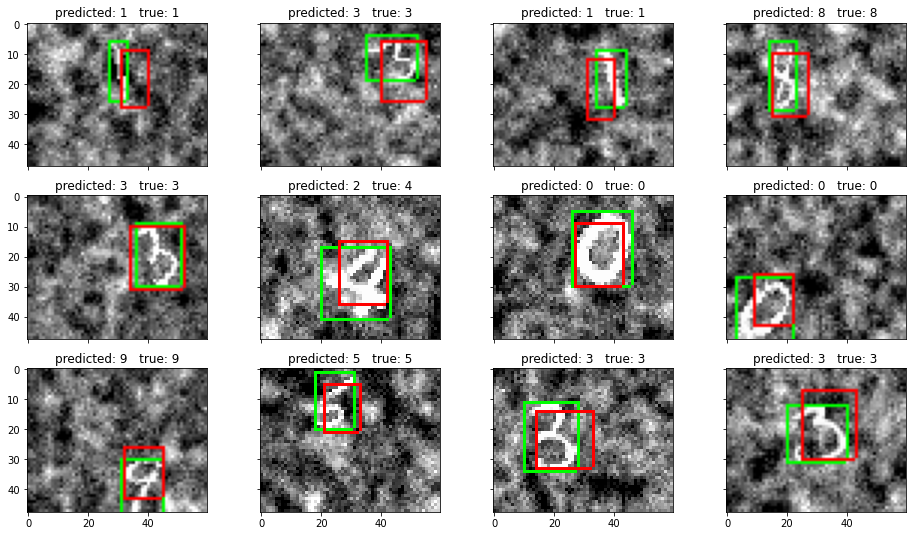

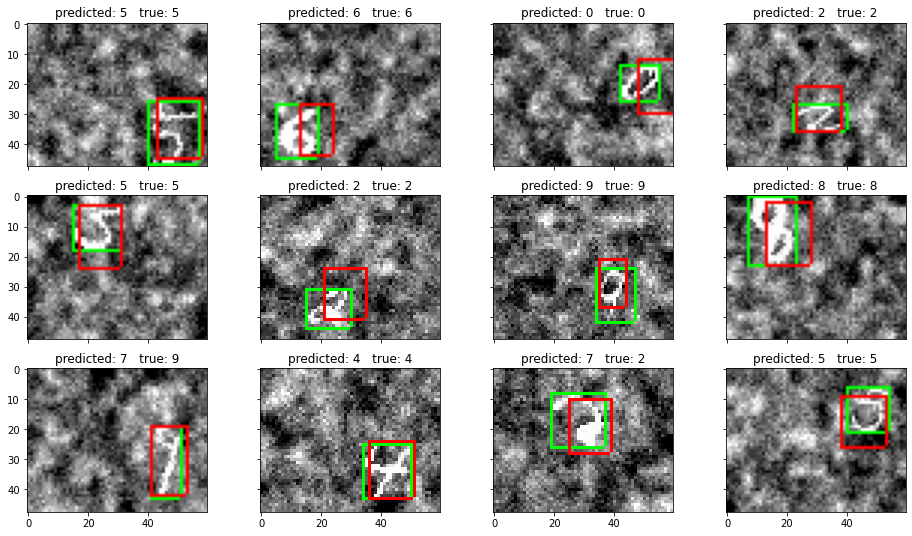

In [7]:
nrows=3
ncols=4
model.eval()

for data in [data_train, data_val]:
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*4, nrows*3), sharex=True, sharey=True)
    for i, ax in enumerate(axs.flat):
        
        img_raw = data[i][0]
        img = normalizer(img_raw)
        y_true = data[i][1]
        box = y_true[1:5]
        with torch.no_grad():
            y_pred = model(img.unsqueeze(0).to(device=device))
        label = torch.argmax(y_pred[:, 5:], 1)
        box_pred = y_pred[0, 1:5]

        rgb_img = add_bb_to_img(img_raw, box, color='green')
        rgb_img = add_bb_to_img(rgb_img, box_pred, color='red')
        ax.imshow(rgb_img.permute(1, 2, 0))
        ax.set_title("predicted: " + str(label.item()) + "   true: " + str(int(y_true[-1])))
    plt.show()

### Model selection and evaluation

In [8]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bb, in global frame of ref
    """
    # (x, y, w, h)
    # ----------------- Width --------------------
    # Find the leftmost bb (the bb that has the leftmost left edge)
    # And select the other one.
    if bb1[0]-bb1[2]/2 < bb2[0]-bb2[2]/2:
        bb_s = bb2.clone().detach()
    else:
        bb_s = bb1.clone().detach()
        
    # Find the left most right edge
    right = min(bb1[0]+bb1[2]/2, bb2[0]+bb2[2]/2)
    left = max(bb_s[0] - bb_s[2]/2, 0)
    # w = rightmost end of the left - leftmost end of the right
    w = right - left
    
    # If the left side of the right image doesn't reach the right side
    # of the left image, then there is no overlap
    if w < 0:
        return 0.
    
    # ----------------- Height --------------------
    # Find the top bb (the bb that has the upper top edge)
    # And select the other one
    if bb1[1]-bb1[3]/2 < bb2[1]-bb2[3]/2:
        bb_s = bb2.clone().detach()
    else:
        bb_s = bb1.clone().detach()
        
    # Find the upper bottom edge
    bottom = min(bb1[1]+bb1[3]/2, bb2[1]+bb2[3]/2)
    top = max(bb_s[1] - bb_s[3]/2, 0)
    # w = rightmost end of the left - leftmost end of the right
    h = bottom - top
    
    # If the top side of the bottom image doesn't reach the bottom side
    # of the top image, then there is no overlap
    if h < 0:
        return 0.
    
    # Otherwise overlap is w*h

def IoU(bb1, bb2):
    """
    Compute IoU given 2 bb (local or global)
    """
    inter = intersection(bb1, bb2)
    union = (bb1[2]*bb1[3] + bb2[2]*bb2[3]) - inter
    return inter/union

def compute_IoU_localization(model, loader, preprocessor):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    
    tot = 0.
    iou = 0.

    with torch.no_grad():
        for imgs, y_true in loader:
            imgs = preprocessor(imgs).to(device=device) 
            y_true = y_true.to(device=device)
            y_pred = model(imgs)
            
            for (yt, yp) in zip(y_true, y_pred):

                if yt[0] == 1:
                    tot += 1
                    if (torch.sigmoid(yp[0]) > 0.5):
                        bb1 = yt[1:5]
                        bb2 = yp[1:5]
                        iou += IoU(bb1, bb2)
    return (iou / tot).item()

def compute_accuracy_localization(model, loader, preprocessor):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, y_true in loader:
            imgs = preprocessor(imgs).to(device=device) 
            y_true = y_true.to(device=device)
            y_pred = model(imgs)
            
            for (yt, yp) in zip(y_true, y_pred):
                if yt[0] == 1:
                    total += 1
                    if (torch.sigmoid(yp[0]) > 0.5):
                        _, predicted = yp[5:].max(0)
                        correct += int(predicted == yt[5])
    return (correct / total)
    

In [9]:
print("Training")
iou = compute_IoU_localization(model, train_loader, normalizer)
acc = compute_accuracy_localization(model, train_loader, normalizer)
perf = (iou+acc)/2
print("IoU:  ", iou, "   |   Accuracy:  ", acc, "   |   Performance:  ", perf)
print("Validation")
iou = compute_IoU_localization(model, val_loader, normalizer)
acc = compute_accuracy_localization(model, val_loader, normalizer)
perf = (iou+acc)/2
print("IoU:  ", iou, "   |   Accuracy:  ", acc, "   |   Performance:  ", perf)

Training
IoU:   0.49622446298599243    |   Accuracy:   0.9629074074074074    |   Performance:   0.7295659351966999
Validation
IoU:   0.49587544798851013    |   Accuracy:   0.819    |   Performance:   0.657437723994255


# Detection

In [10]:
def xy_windows(H_in, W_in, H_out, W_out, kernel_size, stride):
    """
    Get x and y coordinates of all windows
    """
    y_start = [(stride[0]*i) / (H_in - 1) for i in range(H_out)]
    y_end = [(kernel_size[0] + stride[0]*i) / (H_in - 1) for i in range(H_out)]
    x_start = [(stride[1]*i) / (W_in - 1) for i in range(W_out)]
    x_end = [(kernel_size[1] + stride[1]*i) / (W_in - 1) for i in range(W_out)]
    return (x_start, x_end, y_start, y_end)

def get_ratios(H_in, W_in, kernel_size):
    """
    Get width and height ratios between image and windows
    """
    rh = H_in / kernel_size[0]
    rw = W_in / kernel_size[1]
    return rh, rw
    
def to_global_bb(bb, xs, ys, rh, rw):
    """
    Convert local bb to global bb
    """
    return [
        bb[0] / rw + xs,
        bb[1] / rh + ys,
        bb[2] / rw,
        bb[3] / rh,
    ]
    
def extract_bb(img, y, stride, kernel_size, pred=True):
    """
    extract list of all global bb from y
    """
    H_out, W_out, _ = y.shape
    H_in, W_in = img.shape[-2:]
    
    # x/y start/end of windows. Note that y <> h and x <> w 
    x_start, x_end, y_start, y_end = xy_windows(
        H_in, W_in, H_out, W_out, kernel_size, stride
    )
    
    rh, rw = get_ratios(H_in, W_in, kernel_size)
    
    l_bb = []
    for h in range(H_out):
        for w in range(W_out):
            if ( (torch.sigmoid(y[h, w, 0]) > 0.5) or (not pred and y[h, w, 0] == 1) ):
                local_bb = y[h, w, 1:5]
                l_bb.append(to_global_bb(local_bb, x_start[w], y_start[h], rh, rw))
    return l_bb

def add_bb_to_img_detection(img, l_bb, color='green'):
    rgb_img = img.clone()
    for bb in l_bb:
        rgb_img = add_bb_to_img(rgb_img, bb, color=color)
    return rgb_img
    
def detection_loss(y_pred, y_true):
    loss = 0.
    (N, H_out, W_out, _) = y_true.shape
    for h in range(H_out):
        for w in range(W_out):
            loss = loss + localization_loss(y_pred[:, h, w, :], y_true[:, h, w, :])
    return loss
    

### Load data and preprocessing

In [11]:
H_in, W_in = 48, 60
kernel_size = (24, 20)
stride = kernel_size
H_out = (H_in - kernel_size[0]) // stride[0] + 1
W_out = (W_in - kernel_size[1]) // stride[1] + 1


mmnist_train = torch.load("detection_train.pt")
mmnist_val = torch.load("detection_val.pt")
mmnist_test = torch.load("detection_test.pt")

print(len(mmnist_train))
print(len(mmnist_val))
print(len(mmnist_test))

6886
774
1254


In [12]:
# Uncomment this to compute mean and std
#imgs_train = torch.stack([img for img, _ in mmnist_train])
#mean = imgs_train.mean()
#std = imgs_train.std()
#print(mean, std)
mean, std = 0.3065, 0.2070
normalizer_detection = transforms.Normalize(mean, std)

### Training

In [13]:
n_epochs = 100
batch_size = 256

torch.manual_seed(123)
train_loader = torch.utils.data.DataLoader(mmnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mmnist_val, batch_size=batch_size, shuffle=True)

models = []
model_names = []
losses_train = []

torch.manual_seed(265)
model_detection = LeNet5Conv(H_in, W_in, H_out, W_out).to(device=device)
model_detection.detection=True
optimizer = optim.SGD(model_detection.parameters(), lr=0.01, momentum=0.9)
loss_fn = detection_loss

loss_train = train(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model_detection,
    loss_fn = loss_fn,
    train_loader = train_loader,
    preprocessor = normalizer_detection,
)

15:44:49.855158  |  Epoch 1  |  Training loss 4.58735
15:44:51.193888  |  Epoch 5  |  Training loss 3.84527
15:44:52.769866  |  Epoch 10  |  Training loss 3.62733
15:44:54.248239  |  Epoch 15  |  Training loss 3.38716
15:44:55.761032  |  Epoch 20  |  Training loss 2.72295
15:44:57.404861  |  Epoch 25  |  Training loss 1.64725
15:44:58.977219  |  Epoch 30  |  Training loss 0.97078
15:45:00.595803  |  Epoch 35  |  Training loss 0.31050
15:45:02.156818  |  Epoch 40  |  Training loss 0.12337
15:45:03.706937  |  Epoch 45  |  Training loss 0.08714
15:45:05.249950  |  Epoch 50  |  Training loss 0.07527
15:45:06.778748  |  Epoch 55  |  Training loss 0.06972
15:45:08.540481  |  Epoch 60  |  Training loss 0.06556
15:45:10.164263  |  Epoch 65  |  Training loss 0.06268
15:45:11.850266  |  Epoch 70  |  Training loss 0.06014
15:45:13.488406  |  Epoch 75  |  Training loss 0.05869
15:45:15.121425  |  Epoch 80  |  Training loss 0.05632
15:45:16.807546  |  Epoch 85  |  Training loss 0.05429
15:45:18.320

### Prediction

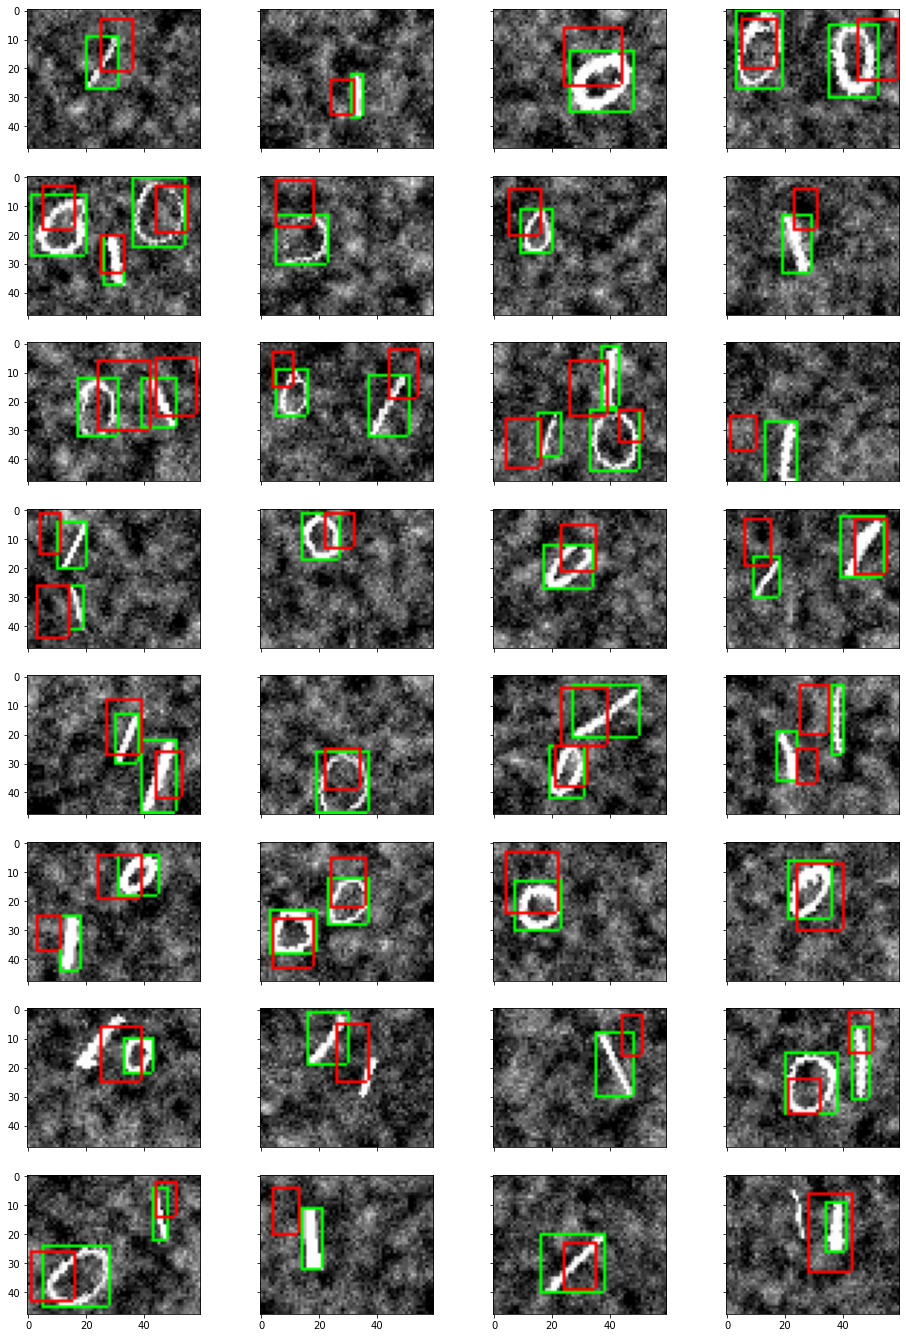

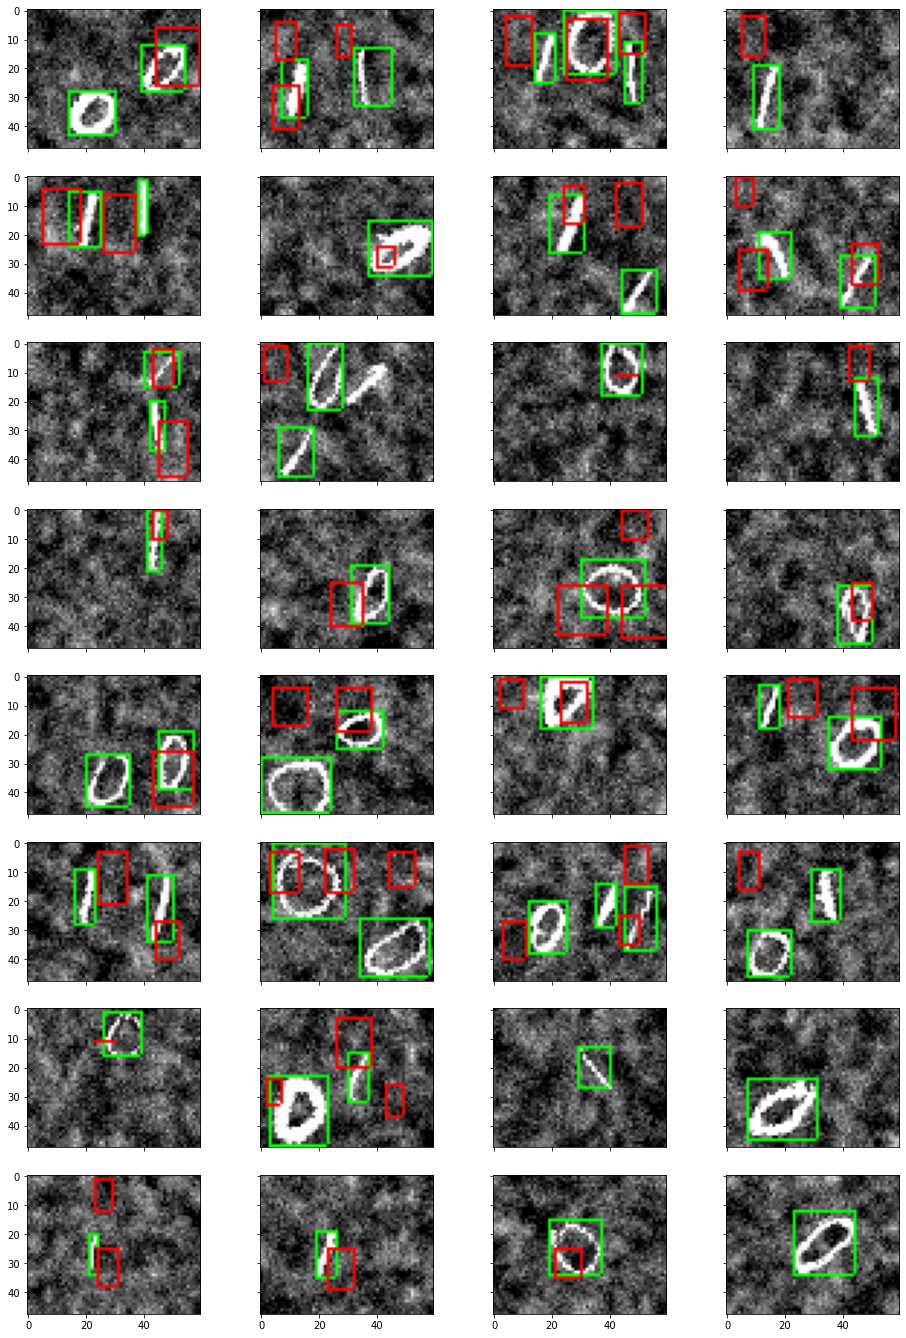

In [14]:
nrows=8
ncols=4
model_detection.eval()


for data in [mmnist_train, mmnist_val]:
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(ncols*4, nrows*3), sharex=True, sharey=True)
    for i, ax in enumerate(axs.flat):
        
        with torch.no_grad():
        
            img_raw = data[i][0]
            img = normalizer_detection(img_raw)
            y_true = data[i][1].squeeze()
            y_pred = model_detection(img.unsqueeze(0).to(device=device)).squeeze()

            l_bb = extract_bb(img, y_true, stride, kernel_size, pred=False)
            rgb_img = add_bb_to_img_detection(img_raw, l_bb, color='green')

            l_bb = extract_bb(img, y_pred, stride, kernel_size)
            rgb_img = add_bb_to_img_detection(rgb_img, l_bb, color='red')

            ax.imshow(rgb_img.permute(1, 2, 0))
    plt.show()

### Model selection and evaluation

In [17]:
def compute_IoU_detection(model, loader, preprocessor):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    
    tot = 0.
    iou = 0.

    with torch.no_grad():
        for imgs, y_true in loader:
            imgs = preprocessor(imgs).to(device=device) 
            y_true = y_true.to(device=device)
            _, H_out, W_out, _ = y_true.shape
            y_pred = model(imgs)
            for (yt, yp) in zip(y_true, y_pred):
                for h in range(H_out):
                    for w in range(W_out):
                        if yt[h, w, 0] == 1:
                            tot += 1
                            if (torch.sigmoid(yp[h, w, 0]) > 0.5):
                                bb1 = yt[h, w, 1:5]
                                bb2 = yp[h, w, 1:5]
                                iou += IoU(bb1, bb2)
    return (iou / tot).item()

def compute_accuracy_detection(model, loader, preprocessor):
    """
    Compute accuracy performance of the model on the given dataset
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, y_true in loader:
            imgs = preprocessor(imgs).to(device=device) 
            y_true = y_true.to(device=device)
            _, H_out, W_out, _ = y_true.shape
            y_pred = model(imgs)
            for (yt, yp) in zip(y_true, y_pred):
                for h in range(H_out):
                    for w in range(W_out):
                        if yt[h, w, 0] == 1:
                            total += 1
                            if (torch.sigmoid(yp[h, w, 0]) > 0.5):
                                _, predicted = torch.max(yp[h, w, 5:], dim=-1)
                                correct += int(predicted == yt[h, w, 5])
    return (correct / total)
    

In [18]:
print("Training")
iou = compute_IoU_detection(model_detection, train_loader, normalizer_detection)
acc = compute_accuracy_detection(model_detection, train_loader, normalizer_detection)
perf = (iou+acc)/2
print("IoU:  ", iou, "   |   Accuracy:  ", acc, "   |   Performance:  ", perf)
print("Validation")
iou = compute_IoU_detection(model_detection, val_loader, normalizer_detection)
acc = compute_accuracy_detection(model_detection, val_loader, normalizer_detection)
perf = (iou+acc)/2
print("IoU:  ", iou, "   |   Accuracy:  ", acc, "   |   Performance:  ", perf)

Training
IoU:   0.30488285422325134    |   Accuracy:   1.0    |   Performance:   0.6524414271116257
Validation
IoU:   0.1498243808746338    |   Accuracy:   0.5290269828291088    |   Performance:   0.3394256818518713
